# Lecture 18: Clenshaw-Curtis Quadrature

Recall that the Newton-Cotes quadrature rules provide exponential convergence if
the integrand is periodic and we integrate over a periodic domain:

$$
I = \int_a^b f(x)\, dx.
$$

In [1]:
using PyPlot
PyPlot.svg(true);

using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16097637509182341903\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1280019239428618734\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/ea8282a8d723f49a68b1d36bce2394d3b9f3b531-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-16097637509182341903\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Error analysis for the trapezoid rule

In [2]:
function trapezoid_rule(f, a, b, N)
    Δ = (b - a)/N
    
    I = 0.5*Δ*f(a) + 0.5*Δ*f(b)
    for n=1:N-1
        I += Δ*f(a + n*Δ)
    end
    
    return I
end

trapezoid_rule (generic function with 1 method)

In [3]:
f(x) = x^2 - x              # Not periodic
g(x) = (cos(12x)*sin(2x))^4  # Periodic

a = -π
b = π

f_exact = 2π^3/3
g_exact = 9π/32

0.8835729338221293

In [4]:
# analyze errors
Ns = 10.0.^(0:0.5:7)

f_error = [(trapezoid_rule(f, a, b, Int64(trunc(N))) - f_exact)/f_exact
        for N in Ns]

g_error = [(trapezoid_rule(g, a, b, Int64(trunc(N))) - g_exact)/g_exact
        for N in Ns];

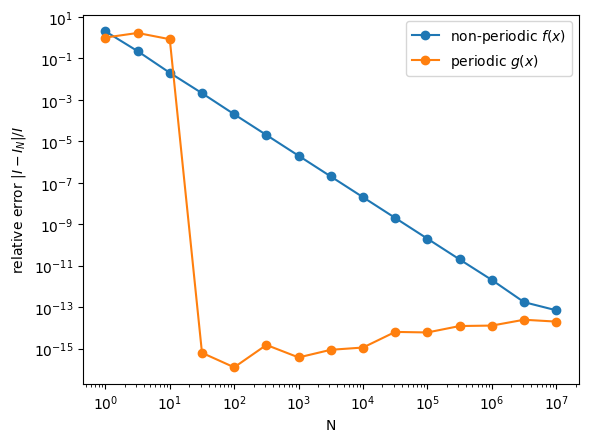

PyObject <matplotlib.legend.Legend object at 0x7fbaaff92a20>

In [5]:
figure()

loglog(Ns, abs.(f_error), "o-", label=L"non-periodic $f(x)$")
loglog(Ns, abs.(g_error), "o-", label=L"periodic $g(x)$")

xlabel("N")
ylabel(L"relative error $|I - I_N|/I$")
legend()

## Clenshaw-Curtis quadrature

Let's say we want to integrate
$$
I = \int_{-1}^1 f(x)\, dx.
$$

Turn into an integral over a periodic function by introducing $x=\cos\theta$,

$$
I = \int_{0}^\pi f(\cos\theta)\,\sin\theta\, d\theta.
$$

In [ ]:
xs = LinRange(-1, 1, 200)
θs = LinRange(0, 2π, 200)

fx = f.(xs)
fcosθ = f.(cos.(θs))
figure()

plot(xs, fx)
xlabel(L"x")
ylabel(L"f(x)")

In [ ]:
figure()

plot(θs, fcosθ)
xlabel(L"θ")
ylabel(L"f(\cos\theta)")
xticks([0, π, 2π])
gca().set_xticklabels(["0", "π", "2π"])

Clenshaw-Curtis quadrature removes discontinuities at the ends of the integration interal
and expresses the numerical integral $I$ through the Fourier series coefficients:

$$
I^{CC} = a_0 + 2\sum_{\nu=1, \nu\text{ even}}^N \frac{a_\nu}{1 - \nu^2},
$$

where

$$
a_\nu = \frac{2}{\pi}\int_0^\pi f(\cos\theta) \cos(\nu\theta)\, d\theta
$$

is evaluated either by FFT or by a Newton-Cotes rule.

In [ ]:
function clenshaw_curtis(f, N)
    """ Naive implementation of Clenshaw-Curtis
    using the trapezoid rule for the Fourier coefficients.
    """     
    # compute even Fourier coefficients
    a = zeros(N+1)
    
    θs = collect(0:N).*π./N
    ts = cos.(θs)
    fts = f.(ts)
    
    # Trapezoid rule approximation for the even Fourier coefficients
    for ν=1:2:N+1
        a[ν] = fts[1]/N + fts[end]/N + (2/N)*sum(fts[2:N].*cos.((ν-1)*θs[2:N]))
    end
    
    # compute integral
    I = a[1]
    for ν=3:N+1
        I += 2a[ν]/(1 - (ν-1)^2)
    end
    
    return I
end

In [ ]:
f(x) = x^2 - x + exp(x)

f_exact = 2.0/3.0 - exp(-1) + exp(1)

In [ ]:
# 2 correct digits
trapezoid_rule(f, -1, 1, 10)

In [ ]:
# Almost exact
clenshaw_curtis(f, 10)

In [ ]:
# Convergence analysis

Ns = Int64.(2.0.^(1:8))

trap_error = [(trapezoid_rule(f, -1, 1, N) - f_exact)/f_exact
        for N in Ns]

cc_error = [(clenshaw_curtis(f, N) - f_exact)/f_exact
        for N in Ns];

In [ ]:
figure()

loglog(Ns, abs.(trap_error), "o-", label="trapezoid rule")
loglog(Ns, abs.(cc_error), "o-", label="Clenshaw-Curtis")

xlabel("N")
ylabel(L"relative error $|I - I_N|/I$")
legend()

In [ ]:
fig, ax = subplots()


@manipulate for N=slider(1:20, value=1, label="N")
    withfig(fig, clear=false) do
        ax.cla()
        
        θs = collect(cos.((0:N)*π/N))
        
        ax.plot(θs, zeros(length(θs)), "xr")

        ax.set_xlim(-1.02, 1.02)
        ax.set_ylim(-1, 1)
        ax.set_yticks([])

        ax.set_xlabel(L"$x$")
        ax.set_title("Clenshaw-Curtis interpolation points (Chebyshev points)")
    end
end